In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

dataset építése:

In [127]:
fires = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_dates.csv")
places = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_places.csv")
weather = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_weather.csv")


C:\Users\Bence\AppData\Local\Temp\ipykernel_18148\175859139.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_weather.csv")


In [128]:
fires = fires.drop(fires[fires["confidence"] < 100].index)
fires["acq_date"] = pd.to_datetime(fires["acq_date"], errors="coerce")
weather["time"] = pd.to_datetime(weather["time"], errors="coerce")
fires_daily = (
    fires.groupby("acq_date")
    .size()
    .reset_index(name="fire_count")
)
fires_daily["fire_occurred"] = (fires_daily["fire_count"] > 0).astype(int)

In [ ]:
places = places.drop(columns=["elevation", "utc_offset_seconds", "timezone", "timezone_abbreviation"])

weather = weather.merge(places, on="location_id", how="left")
numeric_cols = weather.select_dtypes(include=[np.number]).columns
# Group weather by day, aggregate with mean, keep original column names
weather_daily = weather.groupby("time")[numeric_cols].mean().reset_index()

In [130]:
#weather.head().dtypes

In [ ]:
# Merge daily weather and fire data for timeseries creation
df = weather_daily.merge(fires_daily, left_on="time", right_on="acq_date", how="left")
# df = df.drop(columns="time")
df["fire_occurred"].fillna(0, inplace=True)
df.drop(columns=["acq_date"], inplace=True, errors="ignore")
#df.head().dtypes

C:\Users\Bence\AppData\Local\Temp\ipykernel_18148\24506206.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["fire_occurred"].fillna(0, inplace=True)


In [132]:
df["fire_count"].fillna(0, inplace=True)
df.sort_values("time", inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.head())

  location_id       time  weather_code (wmo code)  temperature_2m_mean (°C)  \
0           0 2000-01-18                     53.0                       6.0   
1           1 2000-01-18                     51.0                       3.3   
2           4 2000-01-18                     53.0                       2.9   
3           3 2000-01-18                     53.0                       5.8   
4           2 2000-01-18                      3.0                       5.5   

   temperature_2m_max (°C)  temperature_2m_min (°C)  \
0                      8.9                      3.6   
1                      7.5                     -1.4   
2                      7.1                     -1.8   
3                      7.9                      3.3   
4                     11.9                      0.9   

   apparent_temperature_mean (°C)  apparent_temperature_max (°C)  \
0                             2.3                            4.7   
1                            -1.0                         

C:\Users\Bence\AppData\Local\Temp\ipykernel_18148\1877599873.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["fire_count"].fillna(0, inplace=True)


In [ ]:
window_size = 30  # múltbeli napok
forecast_horizon = 7  # előrejelzési idő

# Use only the specified columns for LSTM features
feature_cols = [
    col for col in [
        "weathercode",
        "temperature_2m_mean",
        "temperature_2m_max",
        "temperature_2m_min",
        "apparent_temperature_mean",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "daylight_duration",
        "sunshine_duration",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "windspeed_10m_max",
        "windgusts_10m_max",
        "winddirection_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ] if col in df.columns
 ]
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

X, y = [], []

for i in range(len(df_scaled) - window_size - forecast_horizon):
    past_window = df_scaled.iloc[i : i + window_size][feature_cols].values
    target_window = df_scaled.iloc[i + window_size : i + window_size + forecast_horizon]["fire_occurred"]
    X.append(past_window)
    y.append(1 if target_window.max() > 0 else 0)

X = np.array(X)
y = np.array(y).astype(np.float32)

print(f"Input shape: {X.shape}  (samples, time_steps, features)")
print(f"Target shape: {y.shape}")

np.savez_compressed("greece_fire_timeseries.npz", X=X, y=y)

Input shape: (40049, 30, 15)  (samples, time_steps, features)
Target shape: (40049,)


In [134]:
cols_scaled = df_scaled.columns.tolist()
print(len(cols_scaled))
cols_df = df.columns.tolist()
print(len(cols_df))
print(len(feature_cols))
print(feature_cols)

26
26
15
['temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)', 'daylight_duration (s)', 'sunshine_duration (s)', 'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'precipitation_hours (h)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)', 'et0_fao_evapotranspiration (mm)']


Model tanítás:

In [136]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import joblib

# Adatok betöltése
data = np.load("greece_fire_timeseries.npz")
X = data["X"]
y = data["y"]

print("Input shape:", X.shape)
print("Target shape:", y.shape)

# Train-test split
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}: Train={len(train_idx)}, Test={len(test_idx)}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

# LSTM modell
model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Kimenet 0-1 között
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Tanítás
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
# Modell mentése
joblib.dump(model, 'model.pkl')

# Értékelés
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Teszt pontosság: {acc*100:.2f}%")


Input shape: (40049, 30, 15)
Target shape: (40049,)
Fold 1: Train=6679, Test=6674
Fold 2: Train=13353, Test=6674
Fold 3: Train=20027, Test=6674
Fold 4: Train=26701, Test=6674
Fold 5: Train=33375, Test=6674
Epoch 1/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8650 - loss: 0.6010 - val_accuracy: 0.9080 - val_loss: 0.5231
Epoch 2/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.8651 - loss: 0.5009 - val_accuracy: 0.9080 - val_loss: 0.4284
Epoch 3/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.8651 - loss: 0.4441 - val_accuracy: 0.9080 - val_loss: 0.3759
Epoch 4/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.8651 - loss: 0.4162 - val_accuracy: 0.9080 - val_loss: 0.3473
Epoch 5/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.8651 - loss: 0.4034 - val_accuracy: 0.9080 - val_loss: 0.3315
Epoch 6/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.8651 - loss: 0.3981 - val_accuracy: 0.9080 - val_loss: 0.3233
Epoch 7/30
522

In [137]:
joblib.dump(model, 'model_15ft_40k_sample.pkl')

['model_15ft_40k_sample.pkl']

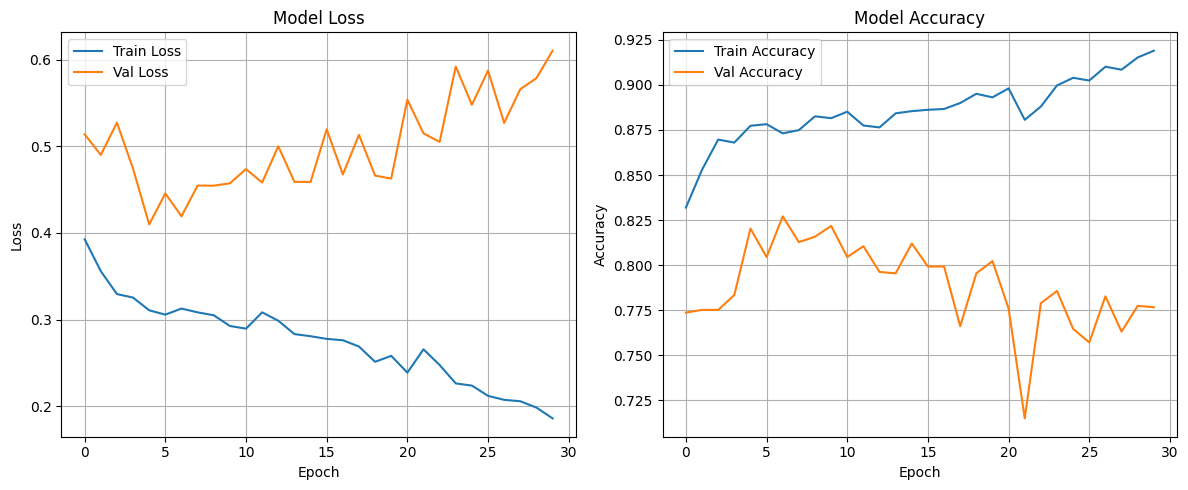

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
